------ Running K means for experiment no. 1 for k = 3
running iteration 0
running iteration 1
running iteration 2
converged


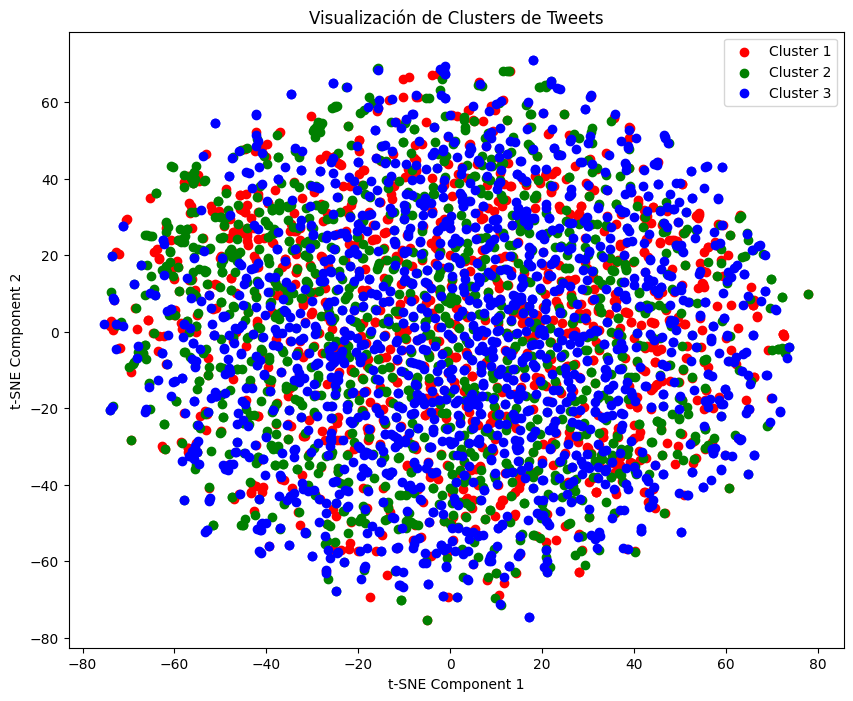

1:  1111 tweets
2:  1295 tweets
3:  1523 tweets


------ Running K means for experiment no. 2 for k = 4
running iteration 0
running iteration 1
converged


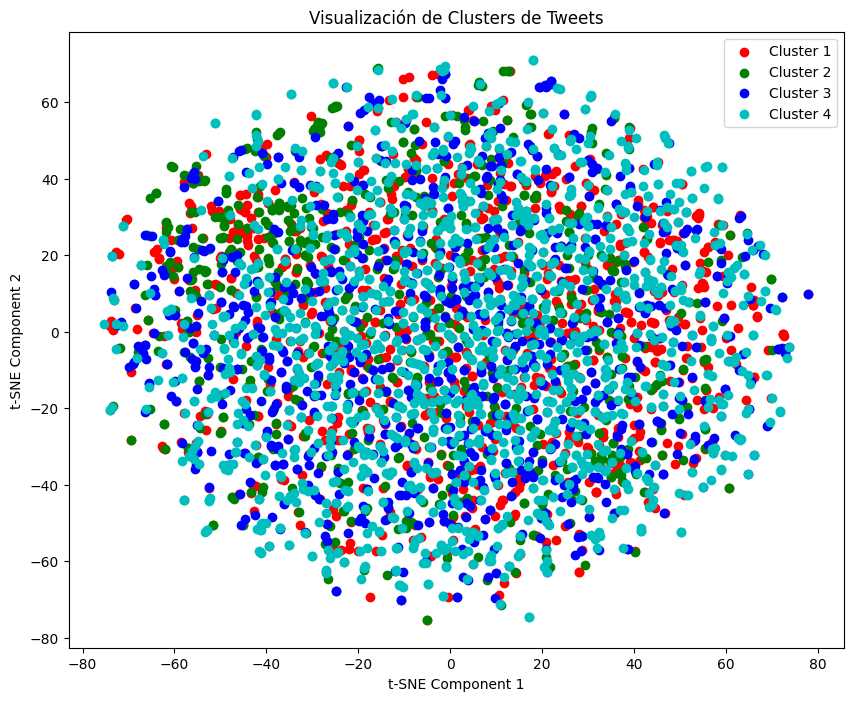

1:  989 tweets
2:  718 tweets
3:  898 tweets
4:  1324 tweets


------ Running K means for experiment no. 3 for k = 5
running iteration 0
running iteration 1
running iteration 2
converged


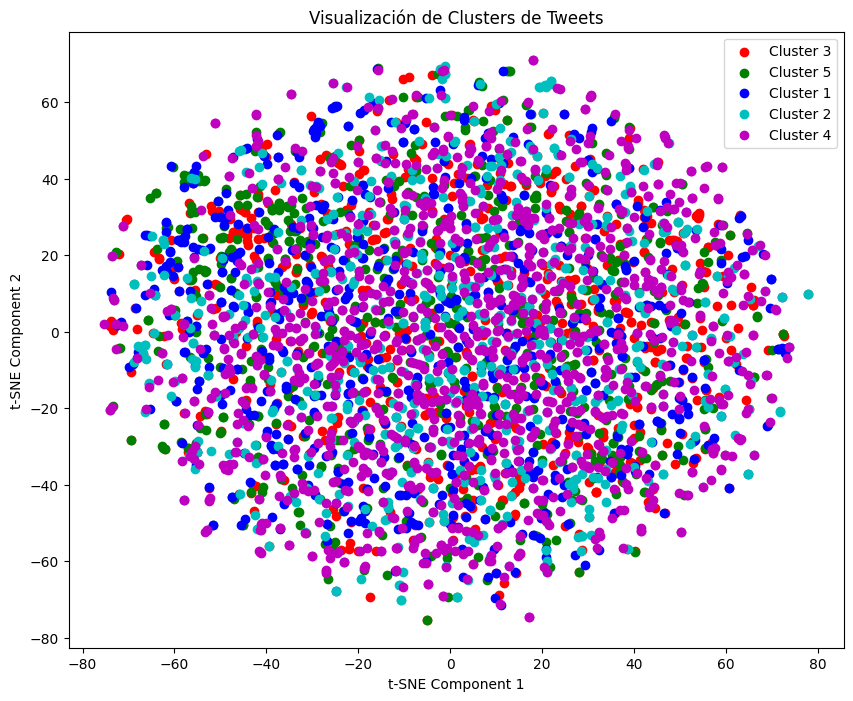

1:  718 tweets
2:  608 tweets
3:  738 tweets
4:  1158 tweets
5:  707 tweets


------ Running K means for experiment no. 4 for k = 6
running iteration 0
running iteration 1
converged


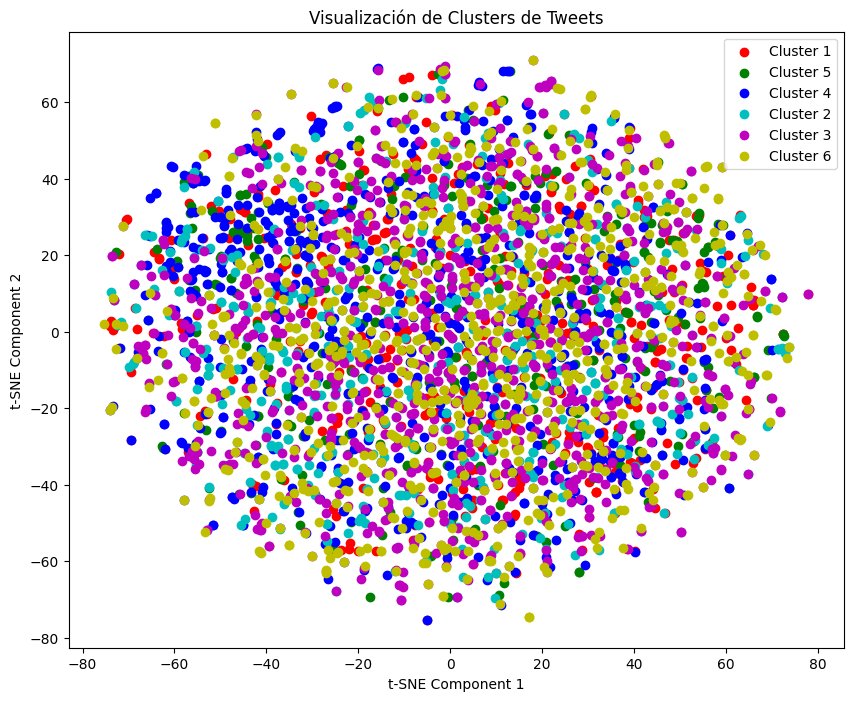

1:  538 tweets
2:  469 tweets
3:  932 tweets
4:  786 tweets
5:  391 tweets
6:  813 tweets


------ Running K means for experiment no. 5 for k = 7
running iteration 0
running iteration 1
running iteration 2
converged


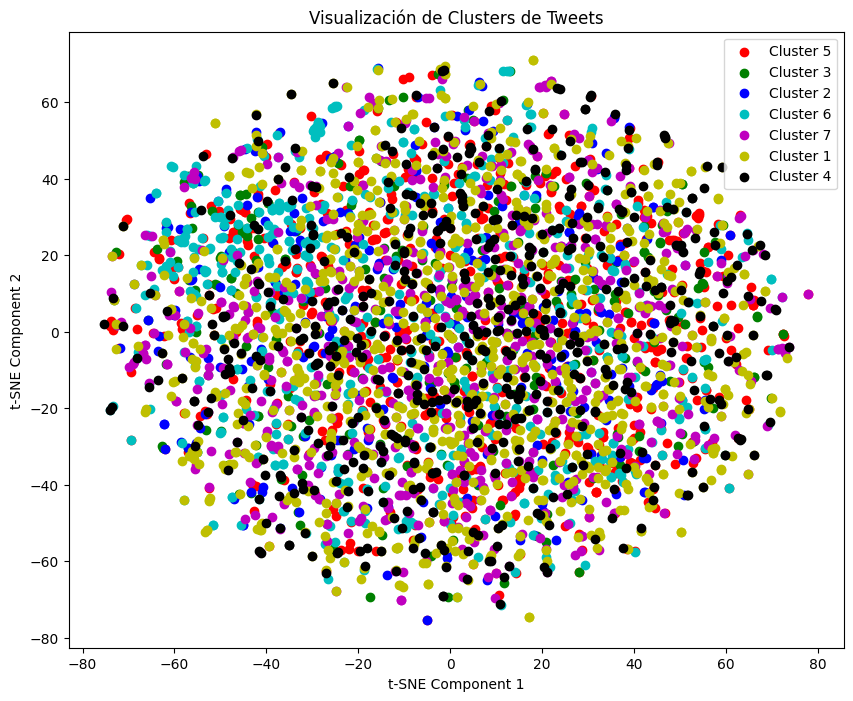

1:  928 tweets
2:  285 tweets
3:  269 tweets
4:  564 tweets
5:  661 tweets
6:  577 tweets
7:  645 tweets




In [9]:
# -*- coding: utf-8 -*-
"""Untitled13.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1mtrhPB4OiZFB189JLWoBZYilH9w2l-1S
"""

import random as rd
import re
import math
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from mpl_toolkits.mplot3d import Axes3D


def pre_process_tweets(url):

    f = open(url, "r", encoding="utf8")
    tweets = list(f)
    list_of_tweets = []

    for i in range(len(tweets)):

        # remove \n from the end after every sentence
        tweets[i] = tweets[i].strip('\n')

        # Remove the tweet id and timestamp
        tweets[i] = tweets[i][50:]

        # Remove any word that starts with the symbol @
        tweets[i] = " ".join(filter(lambda x: x[0] != '@', tweets[i].split()))

        # Remove any URL
        tweets[i] = re.sub(r"http\S+", "", tweets[i])
        tweets[i] = re.sub(r"www\S+", "", tweets[i])

        # remove colons from the end of the sentences (if any) after removing url
        tweets[i] = tweets[i].strip()
        tweet_len = len(tweets[i])
        if tweet_len > 0:
            if tweets[i][len(tweets[i]) - 1] == ':':
                tweets[i] = tweets[i][:len(tweets[i]) - 1]

        # Remove any hash-tags symbols
        tweets[i] = tweets[i].replace('#', '')

        # Convert every word to lowercase
        tweets[i] = tweets[i].lower()

        # remove punctuations
        tweets[i] = tweets[i].translate(str.maketrans('', '', string.punctuation))

        # trim extra spaces
        tweets[i] = " ".join(tweets[i].split())

        # convert each tweet from string type to as list<string> using " " as a delimiter
        list_of_tweets.append(tweets[i].split(' '))

    f.close()

    return list_of_tweets


def k_means(tweets, k=4, max_iterations=50):

    centroids = []

    # initialization, assign random tweets as centroids
    count = 0
    hash_map = dict()
    while count < k:
        random_tweet_idx = rd.randint(0, len(tweets) - 1)
        if random_tweet_idx not in hash_map:
            count += 1
            hash_map[random_tweet_idx] = True
            centroids.append(tweets[random_tweet_idx])

    iter_count = 0
    prev_centroids = []

    # run the iterations until not converged or until the max iteration in not reached
    while (is_converged(prev_centroids, centroids)) == False and (iter_count < max_iterations):

        print("running iteration " + str(iter_count))

        # assignment, assign tweets to the closest centroids
        clusters = assign_cluster(tweets, centroids)

        # to check if k-means converges, keep track of prev_centroids
        prev_centroids = centroids

        # update, update centroid based on clusters formed
        centroids = update_centroids(clusters)
        iter_count = iter_count + 1

    if (iter_count == max_iterations):
        print("max iterations reached, K means not converged")
    else:
        print("converged")

    sse = compute_SSE(clusters)

    return clusters, sse


def is_converged(prev_centroid, new_centroids):

    # false if lengths are not equal
    if len(prev_centroid) != len(new_centroids):
        return False

    # iterate over each entry of clusters and check if they are same
    for c in range(len(new_centroids)):
        if " ".join(new_centroids[c]) != " ".join(prev_centroid[c]):
            return False

    return True


def assign_cluster(tweets, centroids):

    clusters = dict()

    # for every tweet iterate each centroid and assign closest centroid to a it
    for t in range(len(tweets)):
        min_dis = math.inf
        cluster_idx = -1;
        for c in range(len(centroids)):
            dis = getDistance(centroids[c], tweets[t])
            # look for a closest centroid for a tweet

            if centroids[c] == tweets[t]:
                # print("tweet and centroid are equal with c: " + str(c) + ", t" + str(t))
                cluster_idx = c
                min_dis = 0
                break

            if dis < min_dis:
                cluster_idx = c
                min_dis = dis

        # randomise the centroid assignment to a tweet if nothing is common
        if min_dis == 1:
            cluster_idx = rd.randint(0, len(centroids) - 1)

        # assign the closest centroid to a tweet
        clusters.setdefault(cluster_idx, []).append([tweets[t]])
        # print("tweet t: " + str(t) + " is assigned to cluster c: " + str(cluster_idx))
        # add the tweet distance from its closest centroid to compute sse in the end
        last_tweet_idx = len(clusters.setdefault(cluster_idx, [])) - 1
        clusters.setdefault(cluster_idx, [])[last_tweet_idx].append(min_dis)

    return clusters


def update_centroids(clusters):

    centroids = []

    # iterate each cluster and check for a tweet with closest distance sum with all other tweets in the same cluster
    # select that tweet as the centroid for the cluster
    for c in range(len(clusters)):
        min_dis_sum = math.inf
        centroid_idx = -1

        # to avoid redundant calculations
        min_dis_dp = []

        for t1 in range(len(clusters[c])):
            min_dis_dp.append([])
            dis_sum = 0
            # get distances sum for every of tweet t1 with every tweet t2 in a same cluster
            for t2 in range(len(clusters[c])):
                if t1 != t2:
                    if t2 < t1:
                        dis = min_dis_dp[t2][t1]
                    else:
                        dis = getDistance(clusters[c][t1][0], clusters[c][t2][0])

                    min_dis_dp[t1].append(dis)
                    dis_sum += dis
                else:
                    min_dis_dp[t1].append(0)

            # select the tweet with the minimum distances sum as the centroid for the cluster
            if dis_sum < min_dis_sum:
                min_dis_sum = dis_sum
                centroid_idx = t1

        # append the selected tweet to the centroid list
        centroids.append(clusters[c][centroid_idx][0])

    return centroids


def getDistance(tweet1, tweet2):

    # get the intersection
    intersection = set(tweet1).intersection(tweet2)

    # get the union
    union = set().union(tweet1, tweet2)

    # return the jaccard distance
    return 1 - (len(intersection) / len(union))


def compute_SSE(clusters):

    sse = 0
    # iterate every cluster 'c', compute SSE as the sum of square of distances of the tweet from it's centroid
    for c in range(len(clusters)):
        for t in range(len(clusters[c])):
            sse = sse + (clusters[c][t][1] * clusters[c][t][1])

    return sse

def visualize_clusters(clusters, tweet_vectors):
    # Reducir la dimensionalidad usando t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tweets_tsne = tsne.fit_transform(tweet_vectors)

    # Asignar colores a cada cluster
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    color_index = 0

    # Visualizar los clusters
    plt.figure(figsize=(10, 8))
    for cluster_idx, cluster in clusters.items():
        tweets_cluster = [tweet[0] for tweet in cluster]
        tweets_cluster_tsne = tweets_tsne[:len(tweets_cluster)]
        tweets_tsne = tweets_tsne[len(tweets_cluster):]

        plt.scatter(tweets_cluster_tsne[:, 0], tweets_cluster_tsne[:, 1], c=colors[color_index], label=f'Cluster {cluster_idx+1}')
        color_index = (color_index + 1) % len(colors)

    plt.title('Visualización de Clusters de Tweets')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

def vectorize_tweets(tweets):
    # Convertir los tweets en texto plano
    tweet_texts = [' '.join(tweet) for tweet in tweets]

    # Crear un vectorizador TF-IDF
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(tweet_texts)

    return vectors.toarray()

if __name__ == '__main__':

    data_url = 'health+news+in+twitter/Health-Tweets/bbchealth.txt'

    tweets = pre_process_tweets(data_url)

    # default number of experiments to be performed
    experiments = 5

    # default value of K for K-means
    k = 3

    # for every experiment 'e', run K-means
    for e in range(experiments):

        print("------ Running K means for experiment no. " + str((e + 1)) + " for k = " + str(k))

        clusters, _ = k_means(tweets, k)

        # Convertir los tweets a vectores numéricos
        tweet_vectors = vectorize_tweets(tweets)

        visualize_clusters(clusters, tweet_vectors)

        
        # for every cluster 'c', print size of each cluster
        for c in range(len(clusters)):
            print(str(c+1) + ": ", str(len(clusters[c])) + " tweets")
            # # to print tweets in a cluster
            # for t in range(len(clusters[c])):
            #     print("t" + str(t) + ", " + (" ".join(clusters[c][t][0])))

        # print("--> SSE : " + str(sse))
        print('\n')

        # increment k after every experiment
        k = k + 1